In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
data_dir = Path('../data')
peclet_numbers = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]

results = {}
for pe in peclet_numbers:
    csv_file = data_dir / f'pe{pe}.csv'
    if csv_file.exists():
        results[pe] = pd.read_csv(csv_file)
        print(f"Loaded Pe={pe}: {len(results[pe])} values")

Loaded Pe=0.1: 12 values
Loaded Pe=0.2: 12 values
Loaded Pe=0.5: 12 values
Loaded Pe=1: 12 values
Loaded Pe=2: 12 values
Loaded Pe=5: 12 values
Loaded Pe=10: 12 values
Loaded Pe=20: 12 values
Loaded Pe=50: 12 values
Loaded Pe=100: 12 values


In [3]:
def calculate_error(df, scheme_col):
    """Error = 100 * n^-1 * Σ|φ_i - φ̂_i|/φ̂_i"""
    n = len(df)
    analytical = df['phi_analytical']
    numerical = df[scheme_col]
    
    relative_errors = np.abs(numerical - analytical) / analytical
    error_percent = 100 * np.sum(relative_errors) / n
    
    return error_percent

    
# Calculate errors for all schemes at each Peclet number
schemes = ['phi_CDS', 'phi_UDS', 'phi_PLDS']
errors = {scheme: [] for scheme in schemes}

for pe in peclet_numbers:
    if pe in results:
        for scheme in schemes:
            err = calculate_error(results[pe], scheme)
            errors[scheme].append(err)
    else:
        for scheme in schemes:
            errors[scheme].append(np.nan)

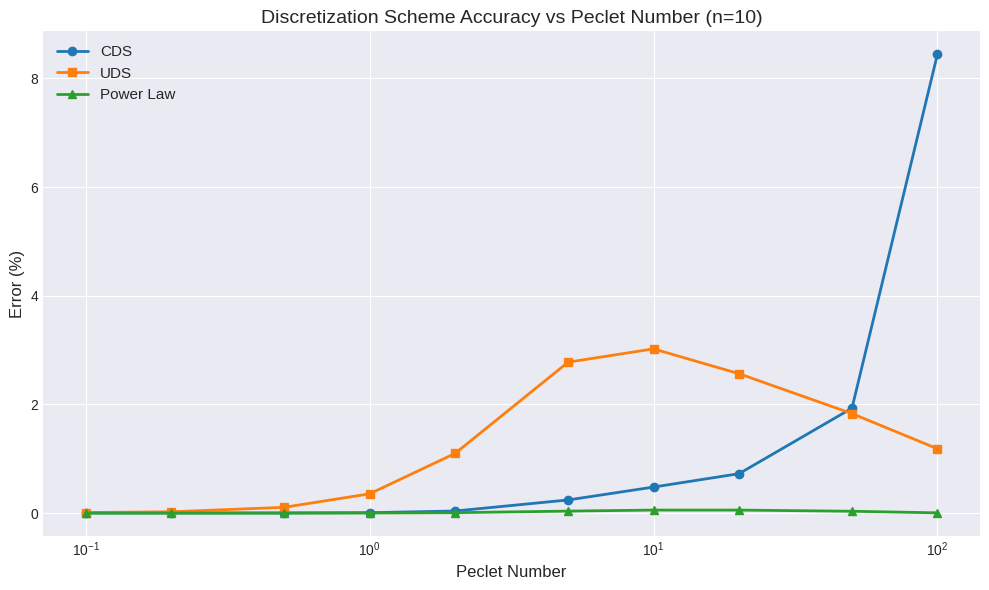


Error summary:
phi_CDS         - Min: 0.00%, Max: 8.44%
phi_UDS         - Min: 0.01%, Max: 3.02%
phi_PLDS        - Min: 0.00%, Max: 0.05%


In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(peclet_numbers, errors['phi_CDS'], 'o-', label='CDS', linewidth=2)
ax.plot(peclet_numbers, errors['phi_UDS'], 's-', label='UDS', linewidth=2)
ax.plot(peclet_numbers, errors['phi_PLDS'], '^-', label='Power Law', linewidth=2)

ax.set_xlabel('Peclet Number', fontsize=12)
ax.set_ylabel('Error (%)', fontsize=12)
ax.set_title('Discretization Scheme Accuracy vs Peclet Number (n=10)', fontsize=14)
ax.set_xscale('log')
ax.grid(True)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\nError summary:")
for scheme in schemes:
    print(f"{scheme:15} - Min: {min(errors[scheme]):.2f}%, Max: {max(errors[scheme]):.2f}%")

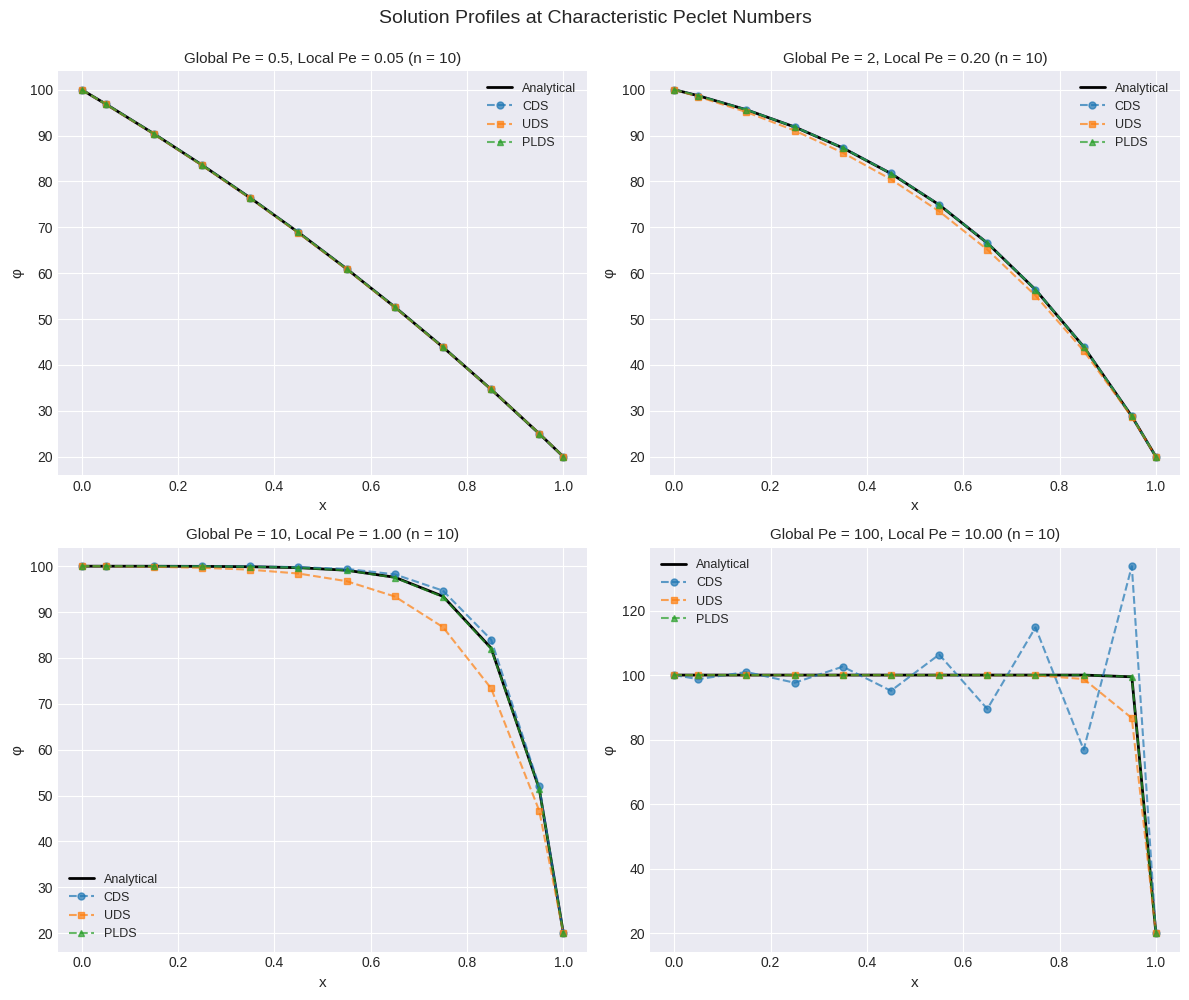

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
key_peclets = [0.5, 2.5, 10, 100]

for ax, pe in zip(axes.flat, key_peclets):
    # Find closest available Pe
    available_pe = min(peclet_numbers, key=lambda x: abs(x - pe))
    if available_pe in results:
        df = results[available_pe]
        
        # Calculate local Peclet number
        n = len(df)-2  # number of cells
        dx = 1.0 / n  # LENGTH / n
        # Local Pe = ρ * u * Δx / Γ = available_pe * Δx (since global Pe = u with ρ=Γ=0.5, L=1)
        local_pe = available_pe * dx
        
        ax.plot(df['x'], df['phi_analytical'], 'k-', label='Analytical', linewidth=2)
        ax.plot(df['x'], df['phi_CDS'], 'o--', label='CDS', alpha=0.7, markersize=5)
        ax.plot(df['x'], df['phi_UDS'], 's--', label='UDS', alpha=0.7, markersize=5)
        ax.plot(df['x'], df['phi_PLDS'], '^--', label='PLDS', alpha=0.7, markersize=5)
        
        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('φ', fontsize=11)
        ax.set_title(f'Global Pe = {available_pe}, Local Pe = {local_pe:.2f} (n = {n})', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True)

fig.suptitle('Solution Profiles at Characteristic Peclet Numbers', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

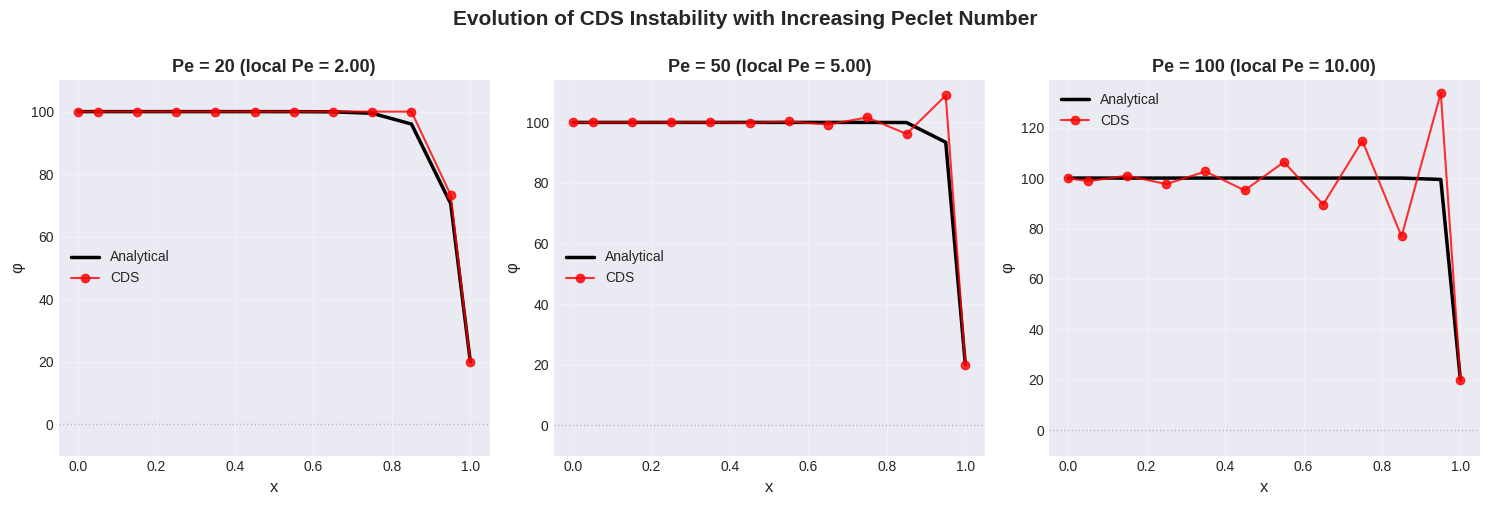


CDS Instability Metrics:
Pe     Min φ        Max φ        Oscillation     Negative cells 
-----------------------------------------------------------------
20     20.00        100.00       80.00           0              
50     20.00        108.89       88.89           0              
100    20.00        133.74       113.74          0              


In [30]:
# CDS Instability Demonstration
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
instability_peclets = [20, 50, 100]

for ax, pe in zip(axes, instability_peclets):
    if pe in results:
        df = results[pe]
        n = len(df)-2
        dx = 1.0 / n
        local_pe = pe * dx
        
        # Plot analytical and CDS only (to highlight instability)
        ax.plot(df['x'], df['phi_analytical'], 'k-', label='Analytical', linewidth=2.5)
        ax.plot(df['x'], df['phi_CDS'], 'o-', label='CDS', color='red', 
                alpha=0.8, markersize=6, linewidth=1.5)
        
        # Add a horizontal line at phi=0 to show unphysical negatives
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('φ', fontsize=12)
        ax.set_title(f'Pe = {pe} (local Pe = {local_pe:.2f})', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        # Set consistent y-limits to show the scale of oscillations
        ax.set_ylim([min(-10, df['phi_CDS'].min() - 5), max(110, df['phi_CDS'].max() + 5)])

fig.suptitle('Evolution of CDS Instability with Increasing Peclet Number', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print quantitative measures of instability
print("\nCDS Instability Metrics:")
print(f"{'Pe':<6} {'Min φ':<12} {'Max φ':<12} {'Oscillation':<15} {'Negative cells':<15}")
print("-" * 65)
for pe in instability_peclets:
    if pe in results:
        df = results[pe]
        min_phi = df['phi_CDS'].min()
        max_phi = df['phi_CDS'].max()
        oscillation = max_phi - min_phi
        negative_cells = (df['phi_CDS'] < 0).sum()
        
        print(f"{pe:<6} {min_phi:<12.2f} {max_phi:<12.2f} {oscillation:<15.2f} {negative_cells:<15}")

In [31]:
grid_sizes = [5, 10, 20, 40, 80, 160, 320, 640, 1280, 2560]
grid_results = {}

for n in grid_sizes:
    csv_file = data_dir / f'grid{n}.csv'
    if csv_file.exists():
        grid_results[n] = pd.read_csv(csv_file)
        print(f"Loaded n={n}: {len(grid_results[n])} cells")

# Calculate dx for each grid
dx_values = [1.0 / n for n in grid_sizes]

Loaded n=5: 7 cells
Loaded n=10: 12 cells
Loaded n=20: 22 cells
Loaded n=40: 42 cells
Loaded n=80: 82 cells
Loaded n=160: 162 cells
Loaded n=320: 322 cells
Loaded n=640: 642 cells
Loaded n=1280: 1282 cells
Loaded n=2560: 2562 cells


In [33]:
grid_errors = {scheme: [] for scheme in schemes}

for n in grid_sizes:
    if n in grid_results:
        for scheme in schemes:
            err = calculate_error(grid_results[n], scheme)
            grid_errors[scheme].append(err)
    else:
        for scheme in schemes:
            grid_errors[scheme].append(np.nan)

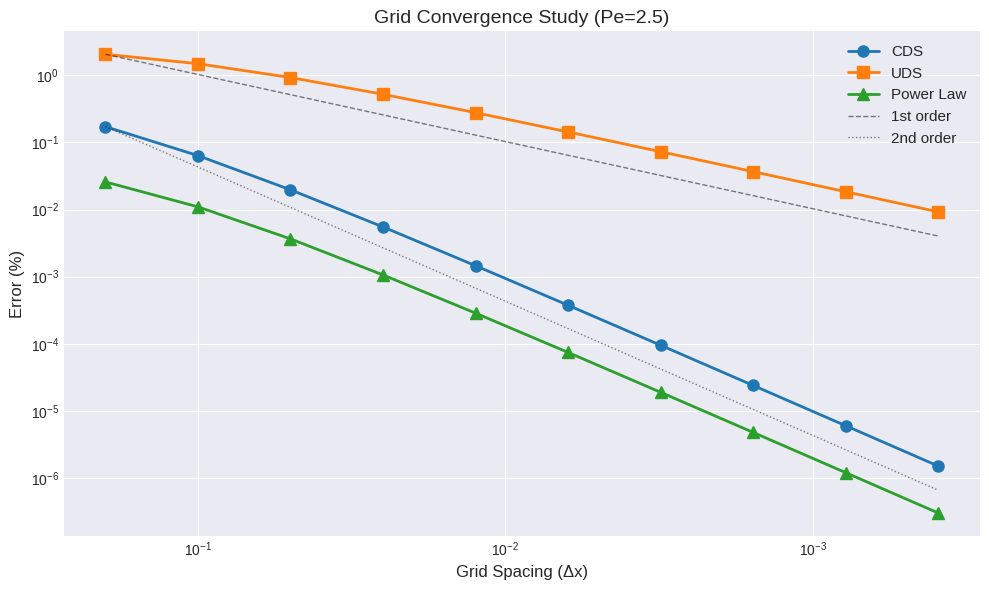


Convergence analysis:
phi_CDS         - Convergence rate: 1.87 (theory: CDS=2, UDS=1)
phi_UDS         - Convergence rate: 0.87 (theory: CDS=2, UDS=1)
phi_PLDS        - Convergence rate: 1.82 (theory: CDS=2, UDS=1)


In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(dx_values, grid_errors['phi_CDS'], 'o-', label='CDS', linewidth=2, markersize=8)
ax.loglog(dx_values, grid_errors['phi_UDS'], 's-', label='UDS', linewidth=2, markersize=8)
ax.loglog(dx_values, grid_errors['phi_PLDS'], '^-', label='Power Law', linewidth=2, markersize=8)

# Add reference lines for convergence rates
dx_ref = np.array([dx_values[0], dx_values[-1]])
# 1st order reference (slope = 1)
first_order = grid_errors['phi_UDS'][0] * (dx_ref / dx_values[0])**1
ax.loglog(dx_ref, first_order, 'k--', alpha=0.5, linewidth=1, label='1st order')

# 2nd order reference (slope = 2)
second_order = grid_errors['phi_CDS'][0] * (dx_ref / dx_values[0])**2
ax.loglog(dx_ref, second_order, 'k:', alpha=0.5, linewidth=1, label='2nd order')

ax.set_xlabel('Grid Spacing (Δx)', fontsize=12)
ax.set_ylabel('Error (%)', fontsize=12)
ax.set_title('Grid Convergence Study (Pe=2.5)', fontsize=14)
ax.grid(True)
ax.legend(fontsize=11)
ax.invert_xaxis()  # Coarse → fine reads left to right

plt.tight_layout()
plt.show()

# Print convergence rates
print("\nConvergence analysis:")
for scheme in schemes:
    # Calculate slope between first and last points (log-log gives order)
    log_dx1, log_dx2 = np.log10(dx_values[0]), np.log10(dx_values[-1])
    log_err1, log_err2 = np.log10(grid_errors[scheme][0]), np.log10(grid_errors[scheme][-1])
    slope = (log_err2 - log_err1) / (log_dx2 - log_dx1)
    print(f"{scheme:15} - Convergence rate: {slope:.2f} (theory: CDS=2, UDS=1)")